# LLM Analyses Results

This notebook analyzes the results from 5 LLM-powered analyses:

1. **Sentiment Analysis of Commits** (from commit labeling)
2. **Skill Extraction from Repos**
3. **Documentation Quality Assessment**
4. **Topic Clustering of Projects**
5. **What Should You Build Next**

Each analysis was run with 3 models: phi3:mini, llama3.1:8b, mistral:7b

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

OUT = Path("..") / "outputs"
DATA = Path("..") / "data"

## Load All Analysis Results

In [2]:
# Load commit labels (Analysis 1)
commit_rows = []
for fp in OUT.glob("commit_labels__*.jsonl"):
    with fp.open() as f:
        for line in f:
            commit_rows.append(json.loads(line))
df_commits = pd.DataFrame(commit_rows)

# Load other analyses (2-5)
analysis_rows = []
with (OUT / "llm_analyses.jsonl").open() as f:
    for line in f:
        analysis_rows.append(json.loads(line))
df_analyses = pd.DataFrame(analysis_rows)

print(f"Commit labels: {len(df_commits)} records")
print(f"Other analyses: {len(df_analyses)} records")
print(f"\nAnalysis types: {df_analyses['analysis'].unique().tolist()}")

Commit labels: 69 records
Other analyses: 42 records

Analysis types: ['skills__Competitive-Programming', 'skills__leetcode-solutions', 'skills__nfl-bdb-2024', 'skills__polars', 'skills__questions', 'skills__roadtrip-planner', 'skills__roadtripplanner', 'readme_quality__leetcode-solutions', 'readme_quality__nfl-bdb-2024', 'readme_quality__polars', 'readme_quality__roadtrip-planner', 'readme_quality__roadtripplanner', 'topic_clustering', 'recommendations']


---
## Analysis 1: Sentiment Analysis of Commits

Extracted tone (positive/neutral/frustrated) from commit messages.

COMMIT SENTIMENT DISTRIBUTION (majority vote across models)
tone
neutral       14
positive       6
frustrated     1
Name: count, dtype: int64


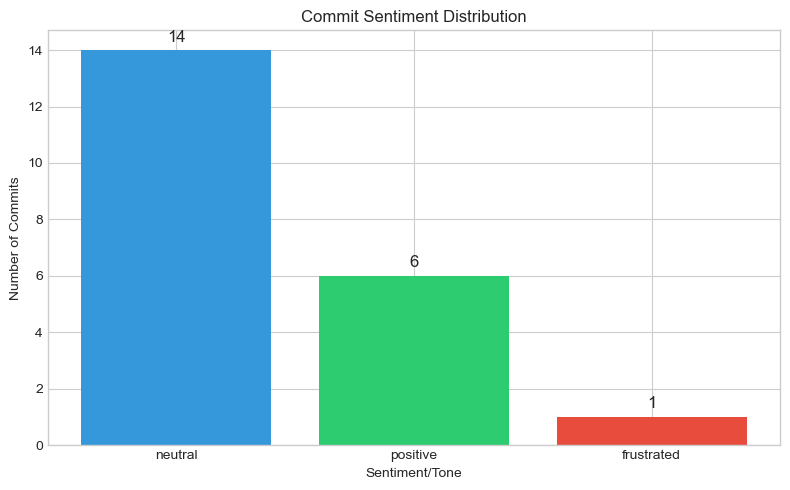

In [3]:
def safe_get(parsed, key):
    if parsed is None:
        return None
    if isinstance(parsed, list):
        return None
    if not isinstance(parsed, dict):
        return None
    val = parsed.get(key)
    if isinstance(val, list):
        return val[0] if val else None
    return val

df_commits["tone"] = df_commits["parsed"].apply(lambda x: safe_get(x, "tone"))
df_commits["type"] = df_commits["parsed"].apply(lambda x: safe_get(x, "type"))

# Aggregate across models (majority vote)
tone_by_msg = df_commits.groupby("input_message")["tone"].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "unknown")

print("COMMIT SENTIMENT DISTRIBUTION (majority vote across models)")
print("="*50)
print(tone_by_msg.value_counts())

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
tone_counts = tone_by_msg.value_counts()
colors = {'positive': '#2ecc71', 'neutral': '#3498db', 'frustrated': '#e74c3c', 'unclear': '#95a5a6'}
bar_colors = [colors.get(t, '#95a5a6') for t in tone_counts.index]
bars = ax.bar(tone_counts.index, tone_counts.values, color=bar_colors)
ax.set_xlabel("Sentiment/Tone")
ax.set_ylabel("Number of Commits")
ax.set_title("Commit Sentiment Distribution")
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            int(bar.get_height()), ha='center', fontsize=12)
plt.tight_layout()
plt.savefig("../outputs/sentiment_distribution.png", dpi=150)
plt.show()

---
## Analysis 2: Skill Extraction from Repos

In [4]:
skills_df = df_analyses[df_analyses["analysis"].str.startswith("skills__")].copy()
skills_df["repo"] = skills_df["analysis"].str.replace("skills__", "")

# Extract skills from llama3.1 (most reliable)
llama_skills = skills_df[skills_df["model"] == "llama3.1:8b"]

all_languages = []
all_frameworks = []
all_domains = []

print("SKILLS EXTRACTED BY REPO")
print("="*60)
for _, row in llama_skills.iterrows():
    if row["parsed"]:
        print(f"\n{row['repo']}:")
        langs = row["parsed"].get("programming_languages", [])
        frameworks = row["parsed"].get("frameworks", [])
        domains = row["parsed"].get("domains", [])
        level = row["parsed"].get("skill_level", "unknown")
        
        print(f"  Languages: {', '.join(langs) if langs else 'None'}")
        print(f"  Frameworks: {', '.join(frameworks) if frameworks else 'None'}")
        print(f"  Domains: {', '.join(domains) if domains else 'None'}")
        print(f"  Skill Level: {level}")
        
        all_languages.extend(langs if langs else [])
        all_frameworks.extend(frameworks if frameworks else [])
        all_domains.extend(domains if domains else [])

SKILLS EXTRACTED BY REPO

Competitive-Programming:
  Languages: None
  Frameworks: None
  Domains: competitive programming
  Skill Level: ['advanced']

leetcode-solutions:
  Languages: Python
  Frameworks: None
  Domains: web development, competitive programming
  Skill Level: ['intermediate']

nfl-bdb-2024:
  Languages: Python
  Frameworks: Jupyter Notebook, Conda
  Domains: data science, web development
  Skill Level: ['intermediate']

polars:
  Languages: Rust, Python, R, Node.js
  Frameworks: Polars, crates.io, PyPi, npmjs
  Domains: data science, web development, competitive programming
  Skill Level: ['advanced']

questions:
  Languages: None
  Frameworks: None
  Domains: web development
  Skill Level: ['beginner']

roadtrip-planner:
  Languages: Python
  Frameworks: None
  Domains: web development, data science, competitive programming
  Skill Level: ['advanced']

roadtripplanner:
  Languages: Python
  Frameworks: None
  Domains: web development, data science
  Skill Level: ['in

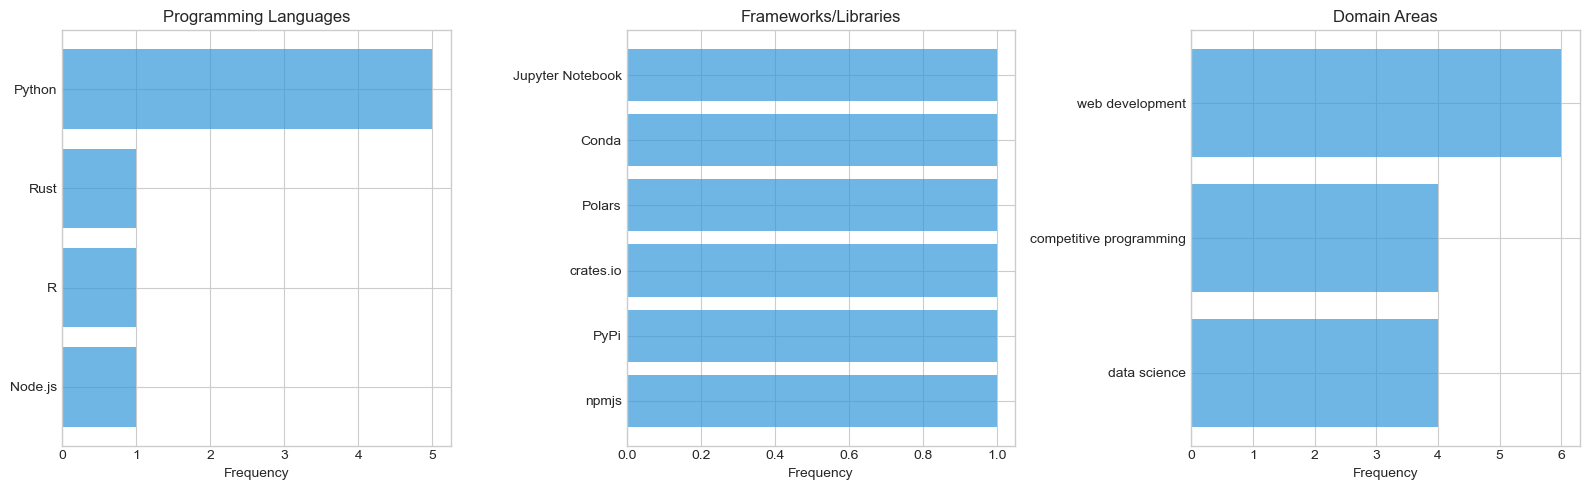

In [5]:
# Aggregate skills
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, data, title in [
    (axes[0], all_languages, "Programming Languages"),
    (axes[1], all_frameworks, "Frameworks/Libraries"),
    (axes[2], all_domains, "Domain Areas")
]:
    if data:
        counts = Counter(data).most_common(8)
        labels, values = zip(*counts) if counts else ([], [])
        ax.barh(labels, values, color='#3498db', alpha=0.7)
        ax.set_xlabel("Frequency")
        ax.set_title(title)
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_title(title)

plt.tight_layout()
plt.savefig("../outputs/skills_extracted.png", dpi=150)
plt.show()

---
## Analysis 3: Documentation Quality Assessment

In [6]:
readme_df = df_analyses[df_analyses["analysis"].str.startswith("readme_quality__")].copy()
readme_df["repo"] = readme_df["analysis"].str.replace("readme_quality__", "")

# Use llama3.1 results
llama_readme = readme_df[readme_df["model"] == "llama3.1:8b"]

print("README QUALITY SCORES")
print("="*60)

scores = []
for _, row in llama_readme.iterrows():
    if row["parsed"]:
        score = row["parsed"].get("overall_score", 0)
        clarity = row["parsed"].get("clarity", 0)
        completeness = row["parsed"].get("completeness", 0)
        suggestions = row["parsed"].get("suggestions", [])
        
        scores.append({"repo": row["repo"], "score": score, "clarity": clarity, "completeness": completeness})
        
        print(f"\n{row['repo']}:")
        print(f"  Overall Score: {score}/10")
        print(f"  Clarity: {clarity:.0%}" if isinstance(clarity, float) else f"  Clarity: {clarity}")
        print(f"  Completeness: {completeness:.0%}" if isinstance(completeness, float) else f"  Completeness: {completeness}")
        if suggestions:
            print(f"  Suggestions: {', '.join(suggestions[:2])}")

scores_df = pd.DataFrame(scores)

README QUALITY SCORES

leetcode-solutions:
  Overall Score: 2/10
  Clarity: 50%
  Completeness: 25%
  Suggestions: Provide a brief description of the project and its purpose., Include installation instructions for users who want to run the code locally.

nfl-bdb-2024:
  Overall Score: 8/10
  Clarity: 90%
  Completeness: 80%
  Suggestions: Consider adding a section on how to run the code and what dependencies are required, Include information about the data sources used for the analysis

polars:
  Overall Score: 6/10
  Clarity: 80%
  Completeness: 40%
  Suggestions: Provide a clear and concise description of the project's purpose and functionality., Include installation instructions for at least one programming language.

roadtrip-planner:
  Overall Score: 2/10
  Clarity: 50%
  Completeness: 25%
  Suggestions: Provide a brief description of the project and its purpose., Include installation instructions for users to set up the project.

roadtripplanner:
  Overall Score: 2/10
  Clarity: 

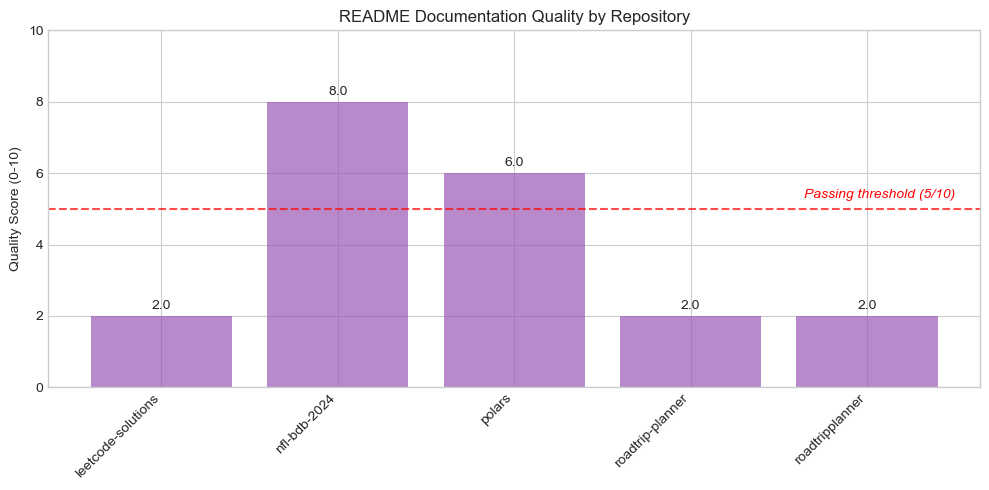

In [7]:
if len(scores_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = range(len(scores_df))
    bars = ax.bar(x, scores_df["score"], color='#9b59b6', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(scores_df["repo"], rotation=45, ha='right')
    ax.set_ylabel("Quality Score (0-10)")
    ax.set_title("README Documentation Quality by Repository")
    ax.set_ylim(0, 10)
    ax.axhline(y=5, color='red', linestyle='--', alpha=0.7)
    ax.text(len(scores_df) - 0.5, 5.3, "Passing threshold (5/10)", color='red', 
            fontsize=10, ha='right', style='italic')
    
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f"{bar.get_height():.1f}", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig("../outputs/readme_quality.png", dpi=150)
    plt.show()

---
## Analysis 4: Topic Clustering of Projects

In [8]:
cluster_df = df_analyses[df_analyses["analysis"] == "topic_clustering"]

print("PROJECT TOPIC CLUSTERS")
print("="*60)

for _, row in cluster_df.iterrows():
    print(f"\nModel: {row['model']}")
    if row["parsed"]:
        clusters = row["parsed"].get("clusters", [])
        primary = row["parsed"].get("primary_focus", "Unknown")
        diversity = row["parsed"].get("diversity_score", 0)
        emerging = row["parsed"].get("emerging_interests", [])
        
        print(f"  Primary Focus: {primary}")
        print(f"  Diversity Score: {diversity}")
        print(f"  Emerging Interests: {', '.join(emerging) if emerging else 'None'}")
        print(f"  Clusters:")
        for c in clusters:
            if isinstance(c, dict):
                name = c.get('cluster_name', 'Unknown')
                repos = c.get('repos', [])
                print(f"    - {name}: {', '.join(repos) if repos else 'N/A'}")

PROJECT TOPIC CLUSTERS

Model: phi3:mini
  Primary Focus: Competitive Programming, LeetCode Solutions, NFL Big Data Bowl 2024 - Tackle Impact Rating (STIR), Polars
  Diversity Score: 0.75
  Emerging Interests: Road trip planning in Python
  Clusters:
    - Competitive Programming: Competitive-Programming
    - LeetCode Solutions: leetcode-solutions
    - NFL Big Data Bowl 2024 - Tackle Impact Rating (STIR): nfl-bdb-2024
    - Polars: polars
    - Road Trip Planner - Nan (Python): roadtrip-planner, roadtripplanner

Model: llama3.1:8b
  Primary Focus: Competitive Programming
  Diversity Score: 0.5
  Emerging Interests: Data Science and Engineering
  Clusters:
    - Competitive Programming: Competive-Programming, leetcode-solutions
    - Data Science and Engineering: polars, nfl-bdb-2024
    - Travel Planning: roadtrip-planner, roadtripplanner

Model: mistral:7b
  Primary Focus: Data Analysis and Competitive Programming
  Diversity Score: 0.8
  Emerging Interests: None
  Clusters:
    - C

---
## Analysis 5: What Should You Build Next

In [9]:
rec_df = df_analyses[df_analyses["analysis"] == "recommendations"]

print("PROJECT RECOMMENDATIONS")
print("="*60)

# Show llama3.1 recommendations (usually best quality)
llama_rec = rec_df[rec_df["model"] == "llama3.1:8b"].iloc[0] if len(rec_df[rec_df["model"] == "llama3.1:8b"]) > 0 else None

if llama_rec is not None and llama_rec["parsed"]:
    parsed = llama_rec["parsed"]
    
    print("\nSTRENGTHS:")
    for s in parsed.get("strengths", []):
        print(f"  - {s}")
    
    print("\nGROWTH AREAS:")
    for g in parsed.get("growth_areas", []):
        print(f"  - {g}")
    
    print("\nNEXT PROJECT IDEAS:")
    for i, proj in enumerate(parsed.get("next_project_ideas", []), 1):
        if isinstance(proj, dict):
            print(f"  {i}. {proj.get('title', 'Unknown')}")
            print(f"     {proj.get('description', '')}")
            print(f"     Why: {proj.get('why_good_fit', '')}")
        else:
            print(f"  {i}. {proj}")
    
    print("\nSKILLS TO LEARN:")
    for skill in parsed.get("skills_to_learn", []):
        if isinstance(skill, dict):
            print(f"  - {skill.get('skill', 'Unknown')}: {skill.get('reason', '')}")
        else:
            print(f"  - {skill}")
    
    print("\nCAREER TRAJECTORY:")
    print(f"  {parsed.get('career_trajectory', 'N/A')}")

PROJECT RECOMMENDATIONS

STRENGTHS:
  - {'name': 'Polars expertise', 'description': 'Your work with Polars demonstrates a strong understanding of efficient data processing and Rust programming.'}
  - {'name': 'Competitive programming skills', 'description': 'Your experience with competitive programming problems showcases your problem-solving abilities and attention to detail.'}

GROWTH AREAS:
  - {'area': 'Web development', 'description': "While you've worked on frontend development, there's room for improvement in this area. Consider learning more about web development frameworks and best practices."}
  - {'area': 'Cloud computing', 'description': 'Your experience with Vercel is a good start, but exploring cloud computing concepts further would be beneficial to enhance your deployment and management skills.'}

NEXT PROJECT IDEAS:
  1. Competitive Programming Platform
     Build a web application to host and manage competitive programming contests. Utilize Polars for efficient data pro

---
## Model Comparison: Reliability & Speed

MODEL PERFORMANCE ACROSS ALL ANALYSES
             total  success_rate  avg_latency
model                                        
llama3.1:8b     14         1.000       14.508
mistral:7b      14         0.929       13.267
phi3:mini       14         0.500       10.702


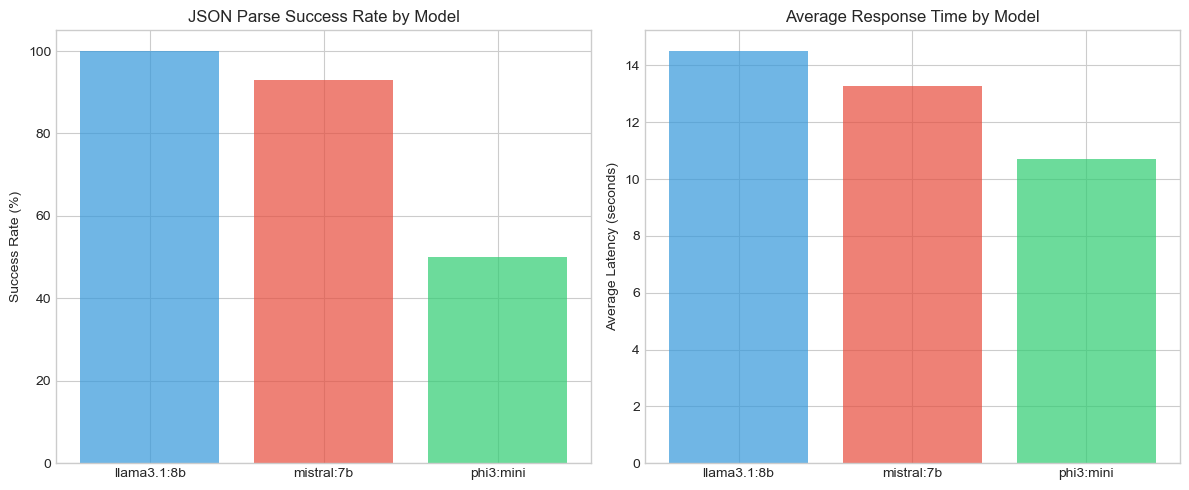

In [10]:
# Combine all results
df_analyses["success"] = df_analyses["error"].isna() & df_analyses["parsed"].notna()

model_perf = df_analyses.groupby("model").agg(
    total=("model", "count"),
    success_rate=("success", "mean"),
    avg_latency=("latency_s", "mean"),
).round(3)

print("MODEL PERFORMANCE ACROSS ALL ANALYSES")
print("="*60)
print(model_perf)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#3498db', '#e74c3c', '#2ecc71']

# Success rate
axes[0].bar(model_perf.index, model_perf["success_rate"] * 100, color=colors, alpha=0.7)
axes[0].set_ylabel("Success Rate (%)")
axes[0].set_title("JSON Parse Success Rate by Model")
axes[0].set_ylim(0, 105)

# Latency
axes[1].bar(model_perf.index, model_perf["avg_latency"], color=colors, alpha=0.7)
axes[1].set_ylabel("Average Latency (seconds)")
axes[1].set_title("Average Response Time by Model")

plt.tight_layout()
plt.savefig("../outputs/model_comparison_all.png", dpi=150)
plt.show()

---
## Summary: Key Insights

In [11]:
print("="*70)
print("KEY INSIGHTS FROM LLM ANALYSES")
print("="*70)

print("\n1. COMMIT SENTIMENT:")
print(f"   Most commits have {tone_by_msg.value_counts().idxmax()} tone")
print(f"   Total commits analyzed: {len(tone_by_msg)}")

print("\n2. TECHNICAL SKILLS:")
top_langs = Counter(all_languages).most_common(3)
print(f"   Top languages: {', '.join([l[0] for l in top_langs])}")
top_domains = Counter(all_domains).most_common(3)
print(f"   Top domains: {', '.join([d[0] for d in top_domains])}")

print("\n3. DOCUMENTATION:")
if len(scores_df) > 0:
    print(f"   Average README score: {scores_df['score'].mean():.1f}/10")
    print(f"   Best documented: {scores_df.loc[scores_df['score'].idxmax(), 'repo']}")

print("\n4. MODEL PERFORMANCE:")
best_model = model_perf["success_rate"].idxmax()
fastest_model = model_perf["avg_latency"].idxmin()
print(f"   Most reliable: {best_model} ({model_perf.loc[best_model, 'success_rate']:.0%} success)")
print(f"   Fastest: {fastest_model} ({model_perf.loc[fastest_model, 'avg_latency']:.1f}s avg)")

KEY INSIGHTS FROM LLM ANALYSES

1. COMMIT SENTIMENT:
   Most commits have neutral tone
   Total commits analyzed: 21

2. TECHNICAL SKILLS:
   Top languages: Python, Rust, R
   Top domains: web development, competitive programming, data science

3. DOCUMENTATION:
   Average README score: 4.0/10
   Best documented: nfl-bdb-2024

4. MODEL PERFORMANCE:
   Most reliable: llama3.1:8b (100% success)
   Fastest: phi3:mini (10.7s avg)
